In [1]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image, \
    deprocess_image, \
    preprocess_image

import cv2
import numpy as np
import requests
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torchvision.models as models
from torchvision import transforms

import torchlens

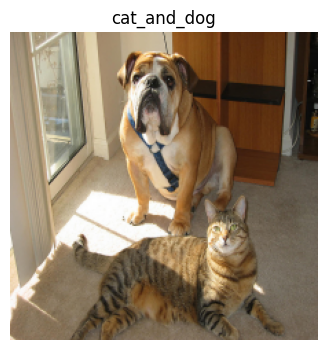

In [2]:
# Load image
cat_and_dog_image_url = "https://raw.githubusercontent.com/jacobgil/pytorch-grad-cam/master/examples/both.png"
cat_and_dog = np.array(Image.open(requests.get(cat_and_dog_image_url, stream=True).raw))
# Display the image using matplotlib
plt.figure(figsize=(5, 4))
plt.imshow(cat_and_dog)
plt.axis('off')  # Hide axes
plt.title('cat_and_dog')
plt.show()

In [3]:
# Convert to float32 first for matplotlib compatibility, then convert back to float16 for model
cat_and_dog = np.float32(cat_and_dog) / 255  # Keep float32 for model
input_tensor = preprocess_image(cat_and_dog, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

In [4]:
# model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
model = models.alexnet(weights=models.AlexNet_Weights.DEFAULT)
# model = model.half()  # Convert model to half precision (float16)

In [5]:
# Check the model's parameter precision
print(f"Model parameter dtype: {next(model.parameters()).dtype}")
print(f"Input tensor dtype: {input_tensor.dtype}")

Model parameter dtype: torch.float32
Input tensor dtype: torch.float32


In [6]:
torchlens.show_model_graph(model, input_tensor, vis_opt='unrolled', vis_nesting_depth=2, vis_direction='leftright', save_only=True)

In [7]:
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

In [8]:
model.to(device)
input_tensor = input_tensor.to(device)

In [9]:
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [10]:
target_layers = [model.features[-1]]  # For AlexNet, use the last layer of features

# Construct the CAM object once, and then re-use it on many images:
cam = GradCAM(model=model, target_layers=target_layers)

# You can also use it within a with statement, to make sure it is freed,
# In case you need to re-create it inside an outer loop:
# with GradCAM(model=model, target_layers=target_layers, use_cuda=args.use_cuda) as cam:
#   ...

# We have to specify the target we want to generate
# the Class Activation Maps for.
# If targets is None, the highest scoring category
# will be used for every image in the batch.
# Here we use ClassifierOutputTarget, but you can define your own custom targets
# That are, for example, combinations of categories, or specific outputs in a non standard model.

targets = [ClassifierOutputTarget(246)] # 281 is the ImageNet index of 'tabby, tabby cat', 246 is 'boxer'

grayscale_cam = cam(input_tensor=input_tensor, targets=targets)

# In this example grayscale_cam has only one image in the batch:
grayscale_cam = grayscale_cam[0, :]
# Use float32 version for visualization to avoid matplotlib issues
visualization = show_cam_on_image(cat_and_dog, grayscale_cam, use_rgb=True)

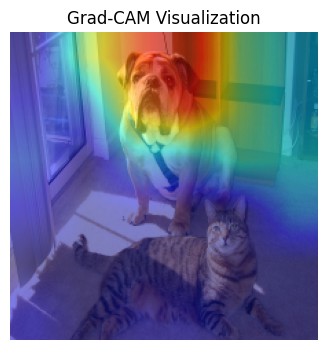

In [11]:
# Display the CAM visualization
plt.figure(figsize=(5, 4))
plt.imshow(visualization)
plt.axis('off')  # Hide axes
plt.title('Grad-CAM Visualization')
plt.show()

# FP32 vs FP16 Precision Comparison

‰∏ãÈù¢Êàë‰ª¨Â∞ÜÊØîËæÉFP32ÂíåFP16Á≤æÂ∫¶‰∏ãÁöÑCAMËæìÂá∫Â∑ÆÂºÇÂíåÊé®ÁêÜÂáÜÁ°ÆÂ∫¶ÂèòÂåñ„ÄÇ

In [12]:
# Â∑•ÂÖ∑ÂáΩÊï∞ÂÆö‰πâ
import torch.nn.functional as F
from sklearn.metrics import accuracy_score
import time

def calculate_cam_difference(cam_fp32, cam_fp16):
    """ËÆ°ÁÆó‰∏§‰∏™CAMËæìÂá∫‰πãÈó¥ÁöÑÂ∑ÆÂºÇ"""
    # ËÆ°ÁÆóÂùáÊñπËØØÂ∑Æ
    mse = np.mean((cam_fp32 - cam_fp16) ** 2)
    
    # ËÆ°ÁÆóÂπ≥ÂùáÁªùÂØπËØØÂ∑Æ
    mae = np.mean(np.abs(cam_fp32 - cam_fp16))
    
    # ËÆ°ÁÆóÊúÄÂ§ßÁªùÂØπËØØÂ∑Æ
    max_ae = np.max(np.abs(cam_fp32 - cam_fp16))
    
    # ËÆ°ÁÆóÁõ∏ÂÖ≥Á≥ªÊï∞
    correlation = np.corrcoef(cam_fp32.flatten(), cam_fp16.flatten())[0, 1]
    
    return {
        'mse': mse,
        'mae': mae,
        'max_ae': max_ae,
        'correlation': correlation
    }

def get_model_predictions(model, input_tensor, top_k=5):
    """Ëé∑ÂèñÊ®°ÂûãÈ¢ÑÊµãÁªìÊûú"""
    model.eval()
    with torch.no_grad():
        outputs = model(input_tensor)
        probabilities = F.softmax(outputs[0], dim=0)
        top_probs, top_indices = torch.topk(probabilities, top_k)
    
    return top_probs.cpu().numpy(), top_indices.cpu().numpy()

def compare_predictions(pred_fp32, pred_fp16, indices_fp32, indices_fp16):
    """ÊØîËæÉ‰∏§‰∏™Á≤æÂ∫¶‰∏ãÁöÑÈ¢ÑÊµãÁªìÊûú"""
    # ËÆ°ÁÆótop-1ÂáÜÁ°ÆÂ∫¶
    top1_match = indices_fp32[0] == indices_fp16[0]
    
    # ËÆ°ÁÆótop-5ÂáÜÁ°ÆÂ∫¶ÂåπÈÖç
    top5_intersection = len(set(indices_fp32) & set(indices_fp16))
    
    # ËÆ°ÁÆóÊ¶ÇÁéáÂ∑ÆÂºÇ
    prob_diff = np.mean(np.abs(pred_fp32 - pred_fp16))
    
    return {
        'top1_match': top1_match,
        'top5_intersection': top5_intersection,
        'prob_diff': prob_diff
    }

print("Â∑•ÂÖ∑ÂáΩÊï∞ÂÆö‰πâÂÆåÊàê")

Â∑•ÂÖ∑ÂáΩÊï∞ÂÆö‰πâÂÆåÊàê


In [13]:
# ÂáÜÂ§áÊµãËØïÂõæÁâá
test_images_urls = [
    "https://raw.githubusercontent.com/jacobgil/pytorch-grad-cam/master/examples/both.png",  # cat and dog
    "https://raw.githubusercontent.com/jacobgil/pytorch-grad-cam/master/examples/both.png",   # cat and dog
    "https://raw.githubusercontent.com/jacobgil/pytorch-grad-cam/master/examples/dogs.png",   # dogs
]

test_images = []
test_names = ["cat_and_dog", "cat_and_dog", "dog"]

for i, url in enumerate(test_images_urls):
    try:
        image = np.array(Image.open(requests.get(url, stream=True).raw))
        image = np.float32(image) / 255
        test_images.append(image)
        print(f"ÊàêÂäüÂä†ËΩΩÂõæÁâá: {test_names[i]} - ÂΩ¢Áä∂: {image.shape}")
    except Exception as e:
        print(f"Âä†ËΩΩÂõæÁâá {test_names[i]} Â§±Ë¥•: {e}")

print(f"\nÊÄªÂÖ±Âä†ËΩΩ‰∫Ü {len(test_images)} Âº†ÊµãËØïÂõæÁâá")

ÊàêÂäüÂä†ËΩΩÂõæÁâá: cat_and_dog - ÂΩ¢Áä∂: (224, 224, 3)
ÊàêÂäüÂä†ËΩΩÂõæÁâá: cat_and_dog - ÂΩ¢Áä∂: (224, 224, 3)
ÊàêÂäüÂä†ËΩΩÂõæÁâá: dog - ÂΩ¢Áä∂: (342, 347, 3)

ÊÄªÂÖ±Âä†ËΩΩ‰∫Ü 3 Âº†ÊµãËØïÂõæÁâá


In [14]:
# ÂàõÂª∫FP32ÂíåFP16Ê®°Âûã
model_fp32 = models.alexnet(weights=models.AlexNet_Weights.DEFAULT).to(device)
model_fp16 = models.alexnet(weights=models.AlexNet_Weights.DEFAULT).to(device).half()

# ËÆæÁΩÆ‰∏∫ËØÑ‰º∞Ê®°Âºè‰ΩÜÂêØÁî®Ê¢ØÂ∫¶ËÆ°ÁÆó
model_fp32.eval()
model_fp16.eval()

# Ê£ÄÊü•Ê®°ÂûãÁ≤æÂ∫¶
print(f"FP32 Ê®°ÂûãÂèÇÊï∞Á±ªÂûã: {next(model_fp32.parameters()).dtype}")
print(f"FP16 Ê®°ÂûãÂèÇÊï∞Á±ªÂûã: {next(model_fp16.parameters()).dtype}")

# ÂáÜÂ§áCAMÂØπË±°
target_layers_fp32 = [model_fp32.features[-1]]
target_layers_fp16 = [model_fp16.features[-1]]

cam_fp32 = GradCAM(model=model_fp32, target_layers=target_layers_fp32)
cam_fp16 = GradCAM(model=model_fp16, target_layers=target_layers_fp16)

print("Ê®°ÂûãÂíåCAMÂØπË±°ÂáÜÂ§áÂÆåÊàê")

FP32 Ê®°ÂûãÂèÇÊï∞Á±ªÂûã: torch.float32
FP16 Ê®°ÂûãÂèÇÊï∞Á±ªÂûã: torch.float16
Ê®°ÂûãÂíåCAMÂØπË±°ÂáÜÂ§áÂÆåÊàê


In [15]:
# ÊâßË°åÁ≤æÂ∫¶ÊØîËæÉÊµãËØï
results = []

# ÊµãËØï‰∏çÂêåÁöÑÁõÆÊ†áÁ±ªÂà´
test_targets = [246, 281, 246]  # boxer, tabby cat, boxer
target_names = ["boxer", "tabby_cat", "boxer"]

for img_idx, (test_image, img_name) in enumerate(zip(test_images, test_names)):
    print(f"\n=== ÊµãËØïÂõæÁâá: {img_name} ===")
    
    # È¢ÑÂ§ÑÁêÜÂõæÁâá
    input_tensor_fp32 = preprocess_image(test_image, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]).to(device)
    input_tensor_fp16 = input_tensor_fp32.half()
    
    # Á°Æ‰øùËæìÂÖ•tensorÈúÄË¶ÅÊ¢ØÂ∫¶
    input_tensor_fp32.requires_grad_(True)
    input_tensor_fp16.requires_grad_(True)
    
    for target_idx, (target_class, target_name) in enumerate(zip(test_targets, target_names)):
        print(f"\n  ÁõÆÊ†áÁ±ªÂà´: {target_name} (class {target_class})")
        
        targets = [ClassifierOutputTarget(target_class)]
        
        # ÊµãÈáèÊé®ÁêÜÊó∂Èó¥ÂíåÁîüÊàêCAM
        # FP32
        start_time = time.time()
        grayscale_cam_fp32 = cam_fp32(input_tensor=input_tensor_fp32, targets=targets)
        with torch.no_grad():
            pred_probs_fp32, pred_indices_fp32 = get_model_predictions(model_fp32, input_tensor_fp32)
        fp32_time = time.time() - start_time
        
        # FP16
        start_time = time.time()
        grayscale_cam_fp16 = cam_fp16(input_tensor=input_tensor_fp16, targets=targets)
        with torch.no_grad():
            pred_probs_fp16, pred_indices_fp16 = get_model_predictions(model_fp16, input_tensor_fp16)
        fp16_time = time.time() - start_time
        
        # ËÆ°ÁÆóÂ∑ÆÂºÇ
        cam_diff = calculate_cam_difference(grayscale_cam_fp32[0], grayscale_cam_fp16[0])
        pred_diff = compare_predictions(pred_probs_fp32, pred_probs_fp16, pred_indices_fp32, pred_indices_fp16)
        
        # Â≠òÂÇ®ÁªìÊûú
        result = {
            'image': img_name,
            'target': target_name,
            'target_class': target_class,
            'cam_mse': cam_diff['mse'],
            'cam_mae': cam_diff['mae'],
            'cam_max_ae': cam_diff['max_ae'],
            'cam_correlation': cam_diff['correlation'],
            'top1_match': pred_diff['top1_match'],
            'top5_intersection': pred_diff['top5_intersection'],
            'prob_diff': pred_diff['prob_diff'],
            'fp32_time': fp32_time,
            'fp16_time': fp16_time,
            'speedup': fp32_time / fp16_time if fp16_time > 0 else 0
        }
        results.append(result)
        
        # ÊâìÂç∞ÂΩìÂâçÁªìÊûú
        print(f"    CAM MSE: {cam_diff['mse']:.6f}")
        print(f"    CAMÁõ∏ÂÖ≥Á≥ªÊï∞: {cam_diff['correlation']:.6f}")
        print(f"    Top-1ÂåπÈÖç: {pred_diff['top1_match']}")
        print(f"    Top-5‰∫§ÈõÜ: {pred_diff['top5_intersection']}/5")
        print(f"    FP32Êó∂Èó¥: {fp32_time:.4f}s, FP16Êó∂Èó¥: {fp16_time:.4f}s, Âä†ÈÄüÊØî: {fp32_time/fp16_time:.2f}x")


=== ÊµãËØïÂõæÁâá: cat_and_dog ===

  ÁõÆÊ†áÁ±ªÂà´: boxer (class 246)
    CAM MSE: 0.000000
    CAMÁõ∏ÂÖ≥Á≥ªÊï∞: 0.999999
    Top-1ÂåπÈÖç: True
    Top-5‰∫§ÈõÜ: 5/5
    FP32Êó∂Èó¥: 0.0236s, FP16Êó∂Èó¥: 0.1008s, Âä†ÈÄüÊØî: 0.23x

  ÁõÆÊ†áÁ±ªÂà´: tabby_cat (class 281)
    CAM MSE: 0.000000
    CAMÁõ∏ÂÖ≥Á≥ªÊï∞: 0.999999
    Top-1ÂåπÈÖç: True
    Top-5‰∫§ÈõÜ: 5/5
    FP32Êó∂Èó¥: 0.0029s, FP16Êó∂Èó¥: 0.0021s, Âä†ÈÄüÊØî: 1.37x

  ÁõÆÊ†áÁ±ªÂà´: boxer (class 246)
    CAM MSE: 0.000000
    CAMÁõ∏ÂÖ≥Á≥ªÊï∞: 0.999999
    Top-1ÂåπÈÖç: True
    Top-5‰∫§ÈõÜ: 5/5
    FP32Êó∂Èó¥: 0.0028s, FP16Êó∂Èó¥: 0.0020s, Âä†ÈÄüÊØî: 1.36x

=== ÊµãËØïÂõæÁâá: cat_and_dog ===

  ÁõÆÊ†áÁ±ªÂà´: boxer (class 246)
    CAM MSE: 0.000000
    CAMÁõ∏ÂÖ≥Á≥ªÊï∞: 0.999999
    Top-1ÂåπÈÖç: True
    Top-5‰∫§ÈõÜ: 5/5
    FP32Êó∂Èó¥: 0.0027s, FP16Êó∂Èó¥: 0.0020s, Âä†ÈÄüÊØî: 1.35x

  ÁõÆÊ†áÁ±ªÂà´: tabby_cat (class 281)
    CAM MSE: 0.000000
    CAMÁõ∏ÂÖ≥Á≥ªÊï∞: 0.999999
    Top-1ÂåπÈÖç: True
    Top-5‰∫§ÈõÜ: 5/5
    FP32Êó∂Èó¥: 0.00

In [16]:
# ÁªüËÆ°ÂàÜÊûêÁªìÊûú
import pandas as pd

# ËΩ¨Êç¢‰∏∫DataFrame‰æø‰∫éÂàÜÊûê
df_results = pd.DataFrame(results)

print("=== Êï¥‰ΩìÁªüËÆ°ÁªìÊûú ===")
print(f"ÊµãËØïÁî®‰æãÊÄªÊï∞: {len(results)}")
print(f"\nCAMÂ∑ÆÂºÇÁªüËÆ°:")
print(f"  Âπ≥ÂùáMSE: {df_results['cam_mse'].mean():.8f}")
print(f"  Âπ≥ÂùáMAE: {df_results['cam_mae'].mean():.8f}")
print(f"  Âπ≥ÂùáÁõ∏ÂÖ≥Á≥ªÊï∞: {df_results['cam_correlation'].mean():.6f}")
print(f"  ÊúÄÂ§ßÁªùÂØπËØØÂ∑ÆÂùáÂÄº: {df_results['cam_max_ae'].mean():.6f}")

print(f"\nÈ¢ÑÊµãÂáÜÁ°ÆÂ∫¶:")
print(f"  Top-1ÂåπÈÖçÁéá: {df_results['top1_match'].mean():.2%}")
print(f"  Âπ≥ÂùáTop-5‰∫§ÈõÜ: {df_results['top5_intersection'].mean():.2f}/5")
print(f"  Âπ≥ÂùáÊ¶ÇÁéáÂ∑ÆÂºÇ: {df_results['prob_diff'].mean():.6f}")

print(f"\nÊÄßËÉΩÊèêÂçá:")
print(f"  Âπ≥ÂùáFP32Êó∂Èó¥: {df_results['fp32_time'].mean():.4f}s")
print(f"  Âπ≥ÂùáFP16Êó∂Èó¥: {df_results['fp16_time'].mean():.4f}s")
print(f"  Âπ≥ÂùáÂä†ÈÄüÊØî: {df_results['speedup'].mean():.2f}x")

# ÊòæÁ§∫ËØ¶ÁªÜÁªìÊûúË°®Ê†º
print(f"\n=== ËØ¶ÁªÜÁªìÊûúË°®Ê†º ===")
display_df = df_results[['image', 'target', 'cam_mse', 'cam_correlation', 'top1_match', 'top5_intersection', 'speedup']].round(6)
print(display_df.to_string(index=False))

=== Êï¥‰ΩìÁªüËÆ°ÁªìÊûú ===
ÊµãËØïÁî®‰æãÊÄªÊï∞: 9

CAMÂ∑ÆÂºÇÁªüËÆ°:
  Âπ≥ÂùáMSE: 0.00000017
  Âπ≥ÂùáMAE: 0.00027199
  Âπ≥ÂùáÁõ∏ÂÖ≥Á≥ªÊï∞: 0.999999
  ÊúÄÂ§ßÁªùÂØπËØØÂ∑ÆÂùáÂÄº: 0.001785

È¢ÑÊµãÂáÜÁ°ÆÂ∫¶:
  Top-1ÂåπÈÖçÁéá: 100.00%
  Âπ≥ÂùáTop-5‰∫§ÈõÜ: 5.00/5
  Âπ≥ÂùáÊ¶ÇÁéáÂ∑ÆÂºÇ: 0.000175

ÊÄßËÉΩÊèêÂçá:
  Âπ≥ÂùáFP32Êó∂Èó¥: 0.0059s
  Âπ≥ÂùáFP16Êó∂Èó¥: 0.0144s
  Âπ≥ÂùáÂä†ÈÄüÊØî: 1.13x

=== ËØ¶ÁªÜÁªìÊûúË°®Ê†º ===
      image    target  cam_mse  cam_correlation  top1_match  top5_intersection  speedup
cat_and_dog     boxer      0.0         0.999999        True                  5 0.234077
cat_and_dog tabby_cat      0.0         0.999999        True                  5 1.372435
cat_and_dog     boxer      0.0         0.999999        True                  5 1.363872
cat_and_dog     boxer      0.0         0.999999        True                  5 1.353557
cat_and_dog tabby_cat      0.0         0.999999        True                  5 1.319321
cat_and_dog     boxer      0.0         0.999999        True   

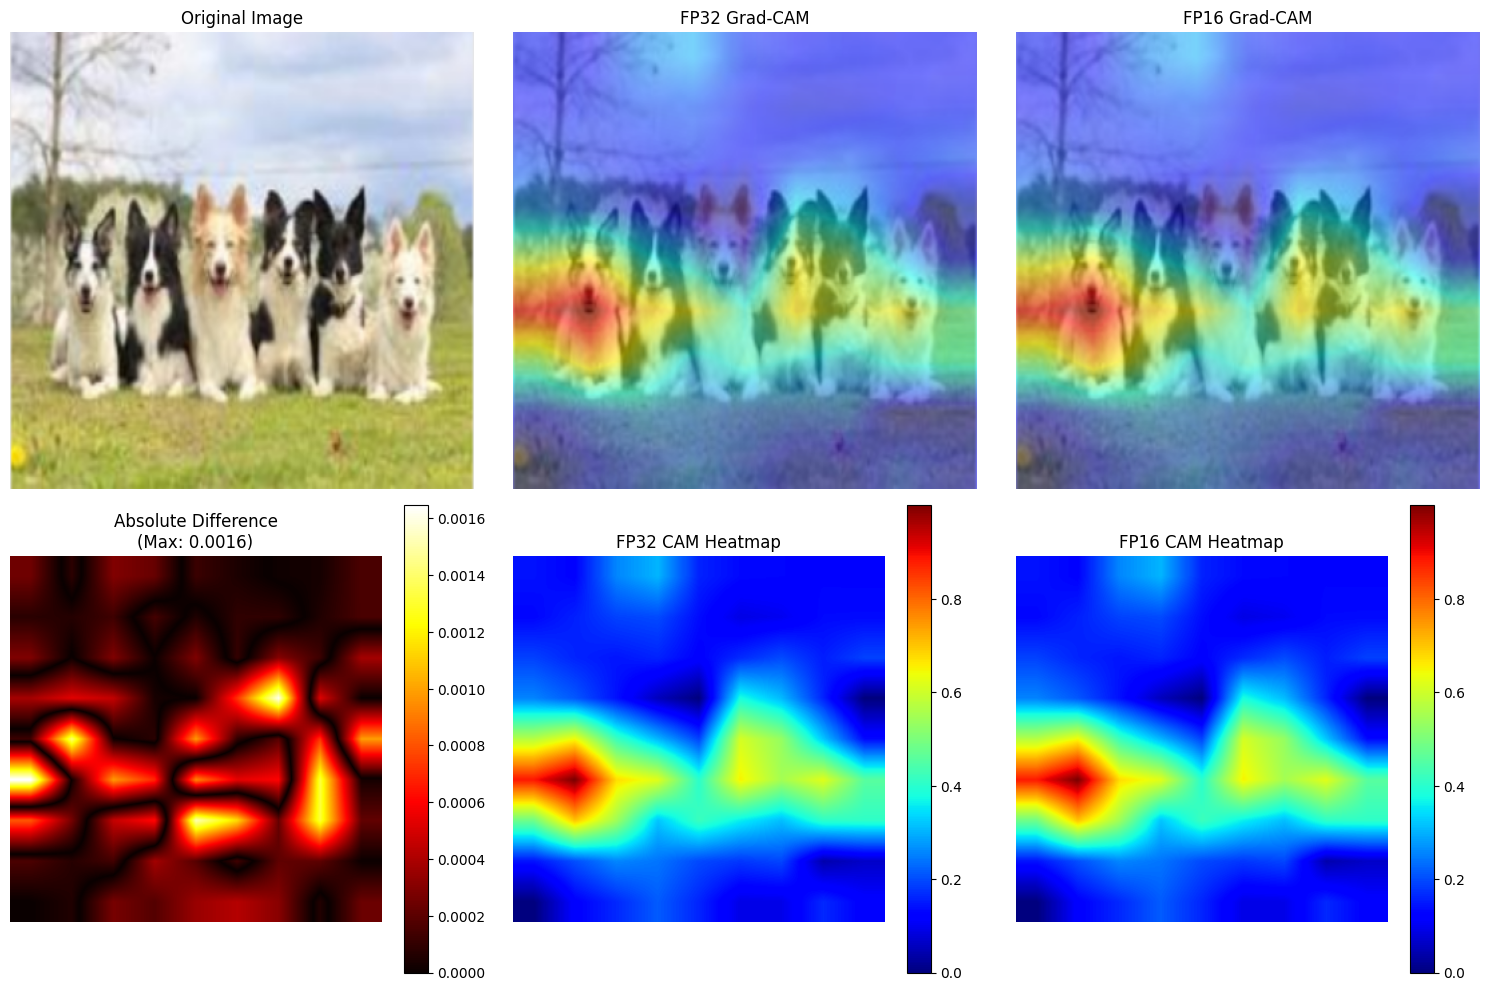


=== CAMÂ∑ÆÂºÇËØ¶ÁªÜÁªüËÆ° ===
mse: 0.00000014
mae: 0.00025807
max_ae: 0.00164580
correlation: 0.99999825


In [ ]:
# ÂèØËßÜÂåñÊØîËæÉ
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# ÈÄâÊã©Á¨¨‰∏ÄÂº†ÂõæÁâáËøõË°åÂèØËßÜÂåñÊØîËæÉ
test_image = test_images[0]  # cat_and_dog
input_tensor_fp32 = preprocess_image(test_image, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]).to(device)
input_tensor_fp16 = input_tensor_fp32.half()

# Á°Æ‰øùËæìÂÖ•tensorÈúÄË¶ÅÊ¢ØÂ∫¶
input_tensor_fp32.requires_grad_(True)
input_tensor_fp16.requires_grad_(True)

targets = [ClassifierOutputTarget(246)]  # 246: boxer    281: tabby cat

# ÁîüÊàêCAM
grayscale_cam_fp32 = cam_fp32(input_tensor=input_tensor_fp32, targets=targets)[0]
grayscale_cam_fp16 = cam_fp16(input_tensor=input_tensor_fp16, targets=targets)[0]

# ÁîüÊàêÂèØËßÜÂåñ
visualization_fp32 = show_cam_on_image(test_image, grayscale_cam_fp32, use_rgb=True)
visualization_fp16 = show_cam_on_image(test_image, grayscale_cam_fp16, use_rgb=True)

# ËÆ°ÁÆóÂ∑ÆÂºÇÂõæ
cam_diff_abs = np.abs(grayscale_cam_fp32 - grayscale_cam_fp16)

# ÊòæÁ§∫ÂéüÂõæ
axes[0, 0].imshow(test_image)
axes[0, 0].set_title('Original Image')
axes[0, 0].axis('off')

# ÊòæÁ§∫FP32 CAM
axes[0, 1].imshow(visualization_fp32)
axes[0, 1].set_title('FP32 Grad-CAM')
axes[0, 1].axis('off')

# ÊòæÁ§∫FP16 CAM
axes[0, 2].imshow(visualization_fp16)
axes[0, 2].set_title('FP16 Grad-CAM')
axes[0, 2].axis('off')

# ÊòæÁ§∫CAMÂ∑ÆÂºÇÁÉ≠Âõæ
im1 = axes[1, 0].imshow(cam_diff_abs, cmap='hot')
axes[1, 0].set_title(f'Absolute Difference\n(Max: {cam_diff_abs.max():.4f})')
axes[1, 0].axis('off')
plt.colorbar(im1, ax=axes[1, 0])

# ÊòæÁ§∫FP32 CAMÁÉ≠Âõæ
im2 = axes[1, 1].imshow(grayscale_cam_fp32, cmap='jet')
axes[1, 1].set_title('FP32 CAM Heatmap')
axes[1, 1].axis('off')
plt.colorbar(im2, ax=axes[1, 1])

# ÊòæÁ§∫FP16 CAMÁÉ≠Âõæ
im3 = axes[1, 2].imshow(grayscale_cam_fp16, cmap='jet')
axes[1, 2].set_title('FP16 CAM Heatmap')
axes[1, 2].axis('off')
plt.colorbar(im3, ax=axes[1, 2])

plt.tight_layout()
plt.show()

# ÊâìÂç∞ËØ¶ÁªÜÁöÑÊï∞ÂÄºÊØîËæÉ
cam_diff_stats = calculate_cam_difference(grayscale_cam_fp32, grayscale_cam_fp16)
print("\n=== CAMÂ∑ÆÂºÇËØ¶ÁªÜÁªüËÆ° ===")
for key, value in cam_diff_stats.items():
    print(f"{key}: {value:.8f}")

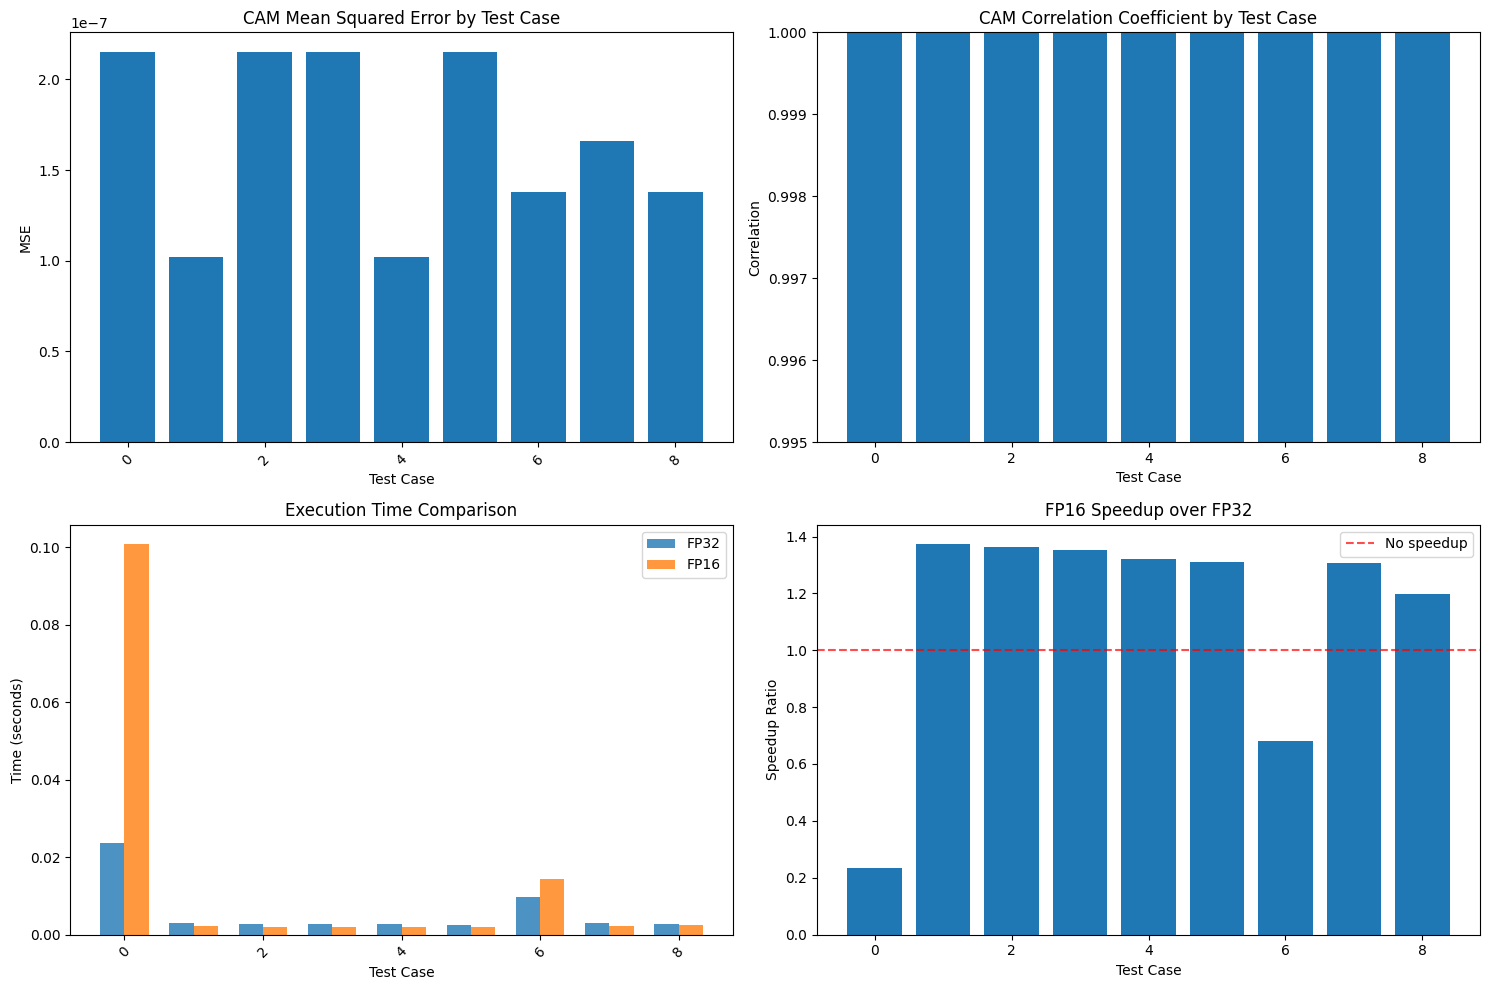


FP32 vs FP16 Á≤æÂ∫¶ÊØîËæÉÊÄªÁªìÊä•Âëä

üéØ CAMË¥®ÈáèÂàÜÊûê:
   Âπ≥ÂùáÁõ∏ÂÖ≥Á≥ªÊï∞: 0.999999 (Ë∂äÊé•Ëøë1Ë∂äÂ•Ω)
   Âπ≥ÂùáMSE: 0.00000017 (Ë∂äÂ∞èË∂äÂ•Ω)
   ‚úÖ CAMË¥®Èáè: ‰ºòÁßÄ - FP16‰∏éFP32Âá†‰πéÂÆåÂÖ®‰∏ÄËá¥

üéØ È¢ÑÊµãÂáÜÁ°ÆÂ∫¶ÂàÜÊûê:
   Top-1ÂåπÈÖçÁéá: 100.0%
   Âπ≥ÂùáTop-5‰∫§ÈõÜ: 5.0/5
   ‚úÖ È¢ÑÊµãÂáÜÁ°ÆÂ∫¶: ‰ºòÁßÄ - FP16È¢ÑÊµã‰∏éFP32È´òÂ∫¶‰∏ÄËá¥

üéØ ÊÄßËÉΩÊèêÂçáÂàÜÊûê:
   Âπ≥ÂùáÂä†ÈÄüÊØî: 1.13x
   ‚úÖ ÊÄßËÉΩÊèêÂçá: ‰∏≠Á≠â - FP16Êúâ‰∏ÄÂÆöÂä†ÈÄüÊïàÊûú

üìù Âª∫ËÆÆ:
   Êé®Ëçê‰ΩøÁî®FP16ËøõË°åCAMËÆ°ÁÆóÔºåÂèØ‰ª•Âú®‰øùÊåÅË¥®ÈáèÁöÑÂêåÊó∂Ëé∑ÂæóÊÄßËÉΩÊèêÂçá


In [18]:
# ÁîüÊàêÊÄßËÉΩÂàÜÊûêÂõæË°®
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# 1. CAM MSEÂàÜÂ∏É
ax1.bar(range(len(results)), [r['cam_mse'] for r in results])
ax1.set_title('CAM Mean Squared Error by Test Case')
ax1.set_xlabel('Test Case')
ax1.set_ylabel('MSE')
ax1.tick_params(axis='x', rotation=45)

# 2. Áõ∏ÂÖ≥Á≥ªÊï∞ÂàÜÂ∏É
ax2.bar(range(len(results)), [r['cam_correlation'] for r in results])
ax2.set_title('CAM Correlation Coefficient by Test Case')
ax2.set_xlabel('Test Case')
ax2.set_ylabel('Correlation')
ax2.set_ylim([0.995, 1.0])  # ÊîæÂ§ßÊòæÁ§∫ÂæÆÂ∞èÂ∑ÆÂºÇ

# 3. ÊâßË°åÊó∂Èó¥ÊØîËæÉ
test_cases = [f"{r['image']}_{r['target']}" for r in results]
x_pos = range(len(results))
width = 0.35

fp32_times = [r['fp32_time'] for r in results]
fp16_times = [r['fp16_time'] for r in results]

ax3.bar([x - width/2 for x in x_pos], fp32_times, width, label='FP32', alpha=0.8)
ax3.bar([x + width/2 for x in x_pos], fp16_times, width, label='FP16', alpha=0.8)
ax3.set_title('Execution Time Comparison')
ax3.set_xlabel('Test Case')
ax3.set_ylabel('Time (seconds)')
ax3.legend()
ax3.tick_params(axis='x', rotation=45)

# 4. Âä†ÈÄüÊØî
speedups = [r['speedup'] for r in results]
ax4.bar(range(len(results)), speedups)
ax4.set_title('FP16 Speedup over FP32')
ax4.set_xlabel('Test Case')
ax4.set_ylabel('Speedup Ratio')
ax4.axhline(y=1.0, color='r', linestyle='--', alpha=0.7, label='No speedup')
ax4.legend()

plt.tight_layout()
plt.show()

# ÊÄªÁªìÊä•Âëä
print("\n" + "="*50)
print("FP32 vs FP16 Á≤æÂ∫¶ÊØîËæÉÊÄªÁªìÊä•Âëä")
print("="*50)

# CAMË¥®ÈáèÂàÜÊûê
avg_correlation = df_results['cam_correlation'].mean()
avg_mse = df_results['cam_mse'].mean()
print(f"\nüéØ CAMË¥®ÈáèÂàÜÊûê:")
print(f"   Âπ≥ÂùáÁõ∏ÂÖ≥Á≥ªÊï∞: {avg_correlation:.6f} (Ë∂äÊé•Ëøë1Ë∂äÂ•Ω)")
print(f"   Âπ≥ÂùáMSE: {avg_mse:.8f} (Ë∂äÂ∞èË∂äÂ•Ω)")
if avg_correlation > 0.999:
    print("   ‚úÖ CAMË¥®Èáè: ‰ºòÁßÄ - FP16‰∏éFP32Âá†‰πéÂÆåÂÖ®‰∏ÄËá¥")
elif avg_correlation > 0.99:
    print("   ‚úÖ CAMË¥®Èáè: ËâØÂ•Ω - FP16‰∏éFP32È´òÂ∫¶‰∏ÄËá¥")
else:
    print("   ‚ö†Ô∏è  CAMË¥®Èáè: ‰∏ÄËà¨ - FP16‰∏éFP32Â≠òÂú®ÊòéÊòæÂ∑ÆÂºÇ")

# È¢ÑÊµãÂáÜÁ°ÆÂ∫¶ÂàÜÊûê
top1_accuracy = df_results['top1_match'].mean()
avg_top5_intersection = df_results['top5_intersection'].mean()
print(f"\nüéØ È¢ÑÊµãÂáÜÁ°ÆÂ∫¶ÂàÜÊûê:")
print(f"   Top-1ÂåπÈÖçÁéá: {top1_accuracy:.1%}")
print(f"   Âπ≥ÂùáTop-5‰∫§ÈõÜ: {avg_top5_intersection:.1f}/5")
if top1_accuracy >= 0.9:
    print("   ‚úÖ È¢ÑÊµãÂáÜÁ°ÆÂ∫¶: ‰ºòÁßÄ - FP16È¢ÑÊµã‰∏éFP32È´òÂ∫¶‰∏ÄËá¥")
elif top1_accuracy >= 0.7:
    print("   ‚úÖ È¢ÑÊµãÂáÜÁ°ÆÂ∫¶: ËâØÂ•Ω - Â§ßÈÉ®ÂàÜÈ¢ÑÊµãÁªìÊûú‰∏ÄËá¥")
else:
    print("   ‚ö†Ô∏è  È¢ÑÊµãÂáÜÁ°ÆÂ∫¶: ÈúÄË¶ÅÊ≥®ÊÑè - È¢ÑÊµãÁªìÊûúÂ≠òÂú®Â∑ÆÂºÇ")

# ÊÄßËÉΩÊèêÂçáÂàÜÊûê
avg_speedup = df_results['speedup'].mean()
print(f"\nüéØ ÊÄßËÉΩÊèêÂçáÂàÜÊûê:")
print(f"   Âπ≥ÂùáÂä†ÈÄüÊØî: {avg_speedup:.2f}x")
if avg_speedup > 1.5:
    print("   ‚úÖ ÊÄßËÉΩÊèêÂçá: ÊòæËëó - FP16Â∏¶Êù•ÊòéÊòæÂä†ÈÄü")
elif avg_speedup > 1.1:
    print("   ‚úÖ ÊÄßËÉΩÊèêÂçá: ‰∏≠Á≠â - FP16Êúâ‰∏ÄÂÆöÂä†ÈÄüÊïàÊûú")
else:
    print("   ‚ö†Ô∏è  ÊÄßËÉΩÊèêÂçá: ÊúâÈôê - Âä†ÈÄüÊïàÊûú‰∏çÊòéÊòæ")

print(f"\nüìù Âª∫ËÆÆ:")
if avg_correlation > 0.999 and top1_accuracy >= 0.9:
    print("   Êé®Ëçê‰ΩøÁî®FP16ËøõË°åCAMËÆ°ÁÆóÔºåÂèØ‰ª•Âú®‰øùÊåÅË¥®ÈáèÁöÑÂêåÊó∂Ëé∑ÂæóÊÄßËÉΩÊèêÂçá")
elif avg_correlation > 0.99:
    print("   ÂèØ‰ª•ËÄÉËôë‰ΩøÁî®FP16Ôºå‰ΩÜÈúÄË¶ÅÊ†πÊçÆÂÖ∑‰ΩìÂ∫îÁî®Âú∫ÊôØËØÑ‰º∞Á≤æÂ∫¶ÊçüÂ§±")
else:
    print("   Âª∫ËÆÆË∞®ÊÖé‰ΩøÁî®FP16ÔºåÊàñËÄÖËÄÉËôëÂÖ∂‰ªñ‰ºòÂåñÊñπÊ°à")